In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np
import anndata as ad
import scanpy as sc
import pandas as pd
import os
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from grn_benchmark.src.helper import plot_heatmap
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

# make sure each column can use more horizontal space
pd.set_option('display.max_colwidth', None)

In [7]:
# k562 -> process the chipatlas data -> merge
# HEK -> check the atlas data
!ls resources/datasets_raw/chipseq/chipatlas/

fileList.tab		    Oth.Dig.50.AllAg.HCT_116.bed
Oth.Bld.50.AllAg.K-562.bed  Oth.Kid.50.AllAg.HEK293-T-REx.bed
Oth.Bld.50.AllAg.PBMC.bed


In [9]:
file_path = "resources/datasets_raw/chipseq/chipatlas/fileList.tab"
df = pd.read_csv(file_path, sep='\t', header=None, dtype=str, comment='#', usecols=range(7))
assert df.shape[0] > 0, f'No entries found in {file_path}'
s_ct = df.iloc[:, 5].fillna('').str.strip().str.casefold()

In [19]:
for item in np.unique(s_ct.values):
    if 'hek' in item.lower():
        print(item)

hek293-t-rex
nhek


In [29]:
!ls resources/grn_benchmark/ground_truth/

GM12878_remap.csv     HCT116_remap.csv	 HepG2_remap.csv     K562_remap.csv
HCT116_chipatlas.csv  HEK293_remap.csv	 K562_chipatlas.csv  PBMC_chipatlas.csv
HCT116_mutual.csv     HEK293T_remap.csv  K562_mutual.csv     remap.csv


In [23]:
!ls resources/datasets_raw/chipseq/chipatlas/

fileList.tab		    Oth.Bld.50.AllAg.PBMC.bed
Oth.Bld.50.AllAg.K-562.bed  Oth.Dig.50.AllAg.HCT_116.bed


FileNotFoundError: [Errno 2] No such file or directory: 'output/sem/sem_scores_ibd.csv'

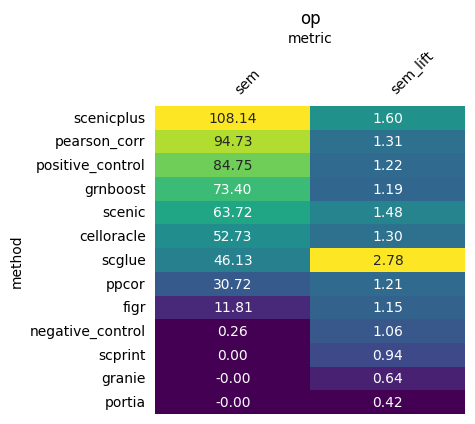

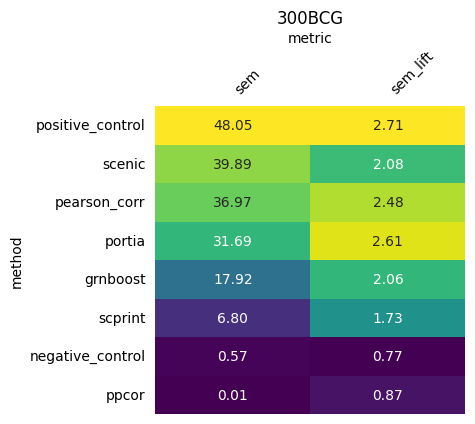

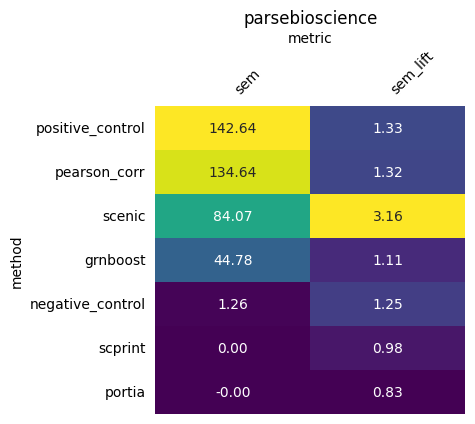

In [ ]:
for dataset in ['op', "300BCG", 'parsebioscience']:
    try:
        df = pd.read_csv(f'output/sem/sem_scores_{dataset}.csv')
    except:
        continue
    df = df.pivot(index='method', columns='metric', values='value')
    df.sort_values('sem', ascending=False, inplace=True)
    plot_heatmap(df, name='',  cmap="viridis")
    plt.title(f'{dataset}')
    # print('\n\n', dataset, '\n', df)

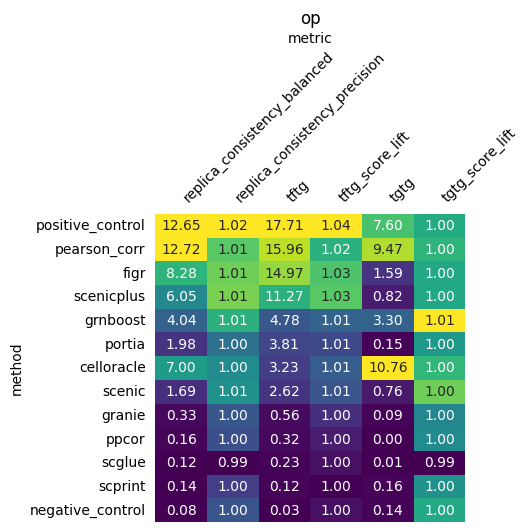

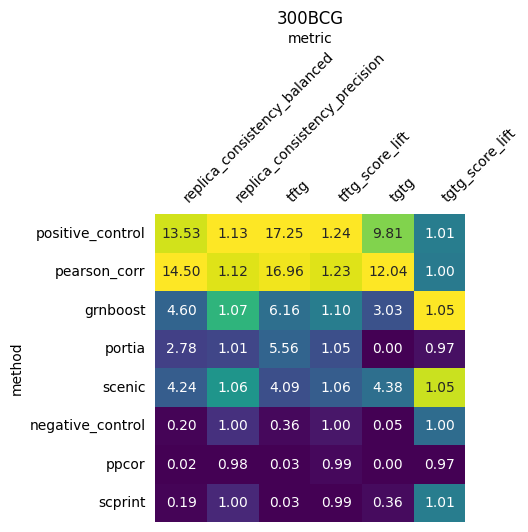

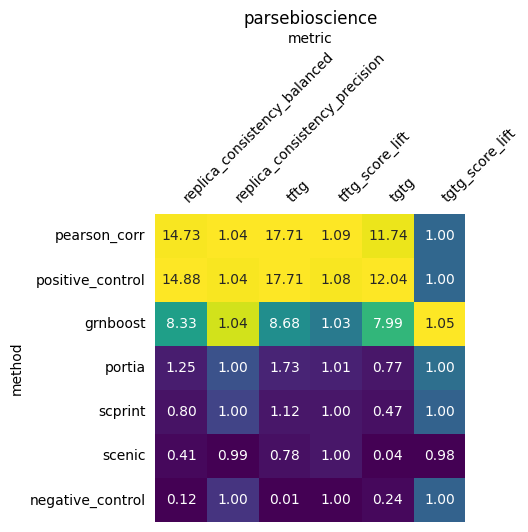

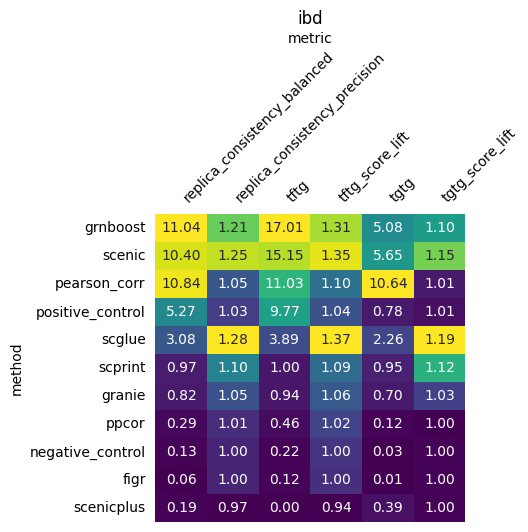

In [57]:
for dataset in ['op', "300BCG", 'parsebioscience', "ibd"]:
    df = pd.read_csv(f'output/replica_consistency/replica_consistency_scores_{dataset}.csv')
    df = df.pivot(index='method', columns='metric', values='value')
    df.sort_values('tftg', ascending=False, inplace=True)
    plot_heatmap(df, name='',  cmap="viridis")
    plt.title(f'{dataset}')
    # print('\n\n', dataset, '\n', df)

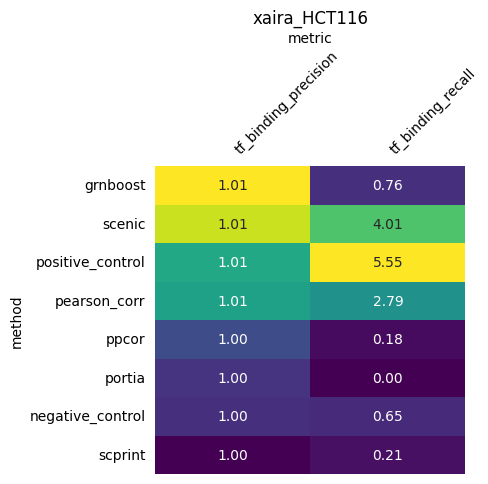

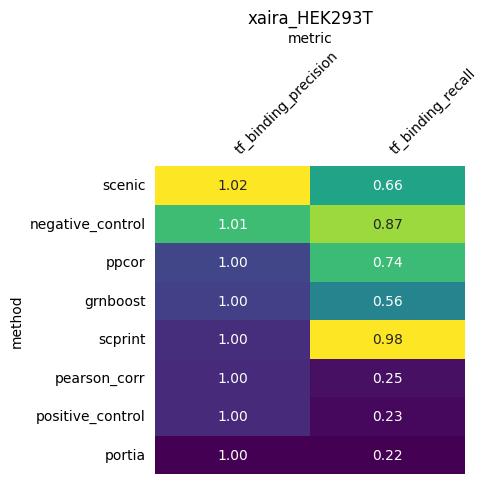

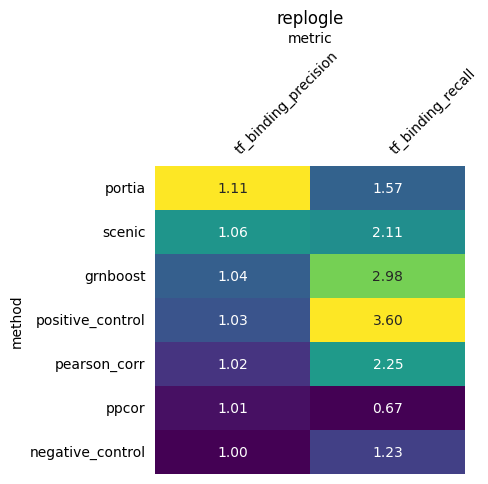

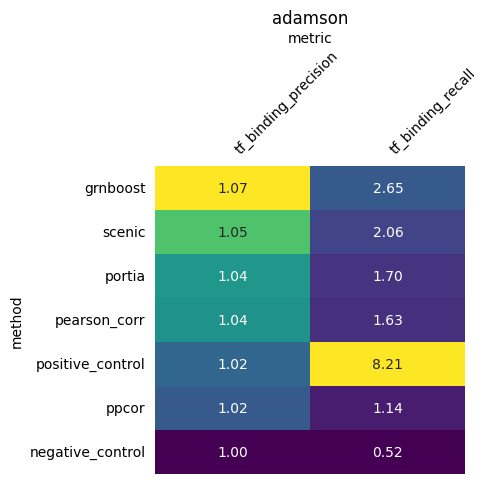

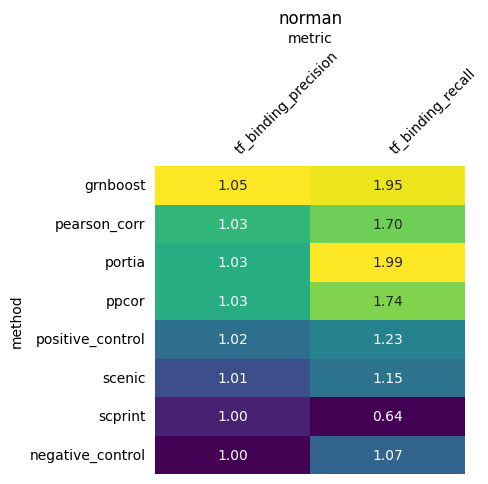

In [37]:
for dataset in [  'xaira_HCT116', 'xaira_HEK293T', 'replogle', 'adamson', 'norman']:
    df = pd.read_csv(f'output/tf_binding/tf_binding_scores_{dataset}.csv')
    # heatplot
    df = df.pivot(index='method', columns='metric', values='value')
    df.sort_values('tf_binding_precision', ascending=False, inplace=True)
    plot_heatmap(df, name='',  cmap="viridis")
    plt.title(f'{dataset}')

In [ ]:
!ls resources/datasets_raw/chipseq/chipatlas/Oth.Kid.50.AllAg.HEK293-T-REx.bed

fileList.tab		    Oth.Dig.50.AllAg.HCT_116.bed
Oth.Bld.50.AllAg.K-562.bed  Oth.Kid.50.AllAg.HEK293-T-REx.bed
Oth.Bld.50.AllAg.PBMC.bed


In [10]:
from src.metrics.tf_binding.acquire.script import read_peak_file
peaks_df = read_peak_file('resources/datasets_raw/chipseq/chipatlas/Oth.Kid.50.AllAg.HEK293-T-REx.bed', source='chip_atlas')

In [14]:
peaks_df['score'] = peaks_df['score'].astype(float)
peaks_df['score'].min(), peaks_df['score'].max(), peaks_df['score'].mean(), peaks_df['score'].median()

(500.0, 1000.0, 691.5878787878788, 657.0)

## Encode

In [ ]:
# !ls resources/datasets_raw/chipseq/encode/metadata.txt
df = pd.read_csv('resources/datasets_raw/chipseq/encode/metadata.txt', sep='\t')
df = df[['Experiment target', 'Biosample term name', 'Experiment accession']]

# Read results of metrics sem

In [13]:
import os
import scanpy as sc
import pandas as pd
import numpy as np

rr_all = []

for dataset in ['300BCG', 'op', 'parsebioscience']:
    for method in (
        "negative_control", "pearson_corr", "positive_control", "ppcor", "portia",
        "scenic", "grnboost", "scprint", "scenicplus", "celloracle",
        "scglue", "figr", "granie"
    ):
        file_name = f'output/sem/sem_{dataset}_{method}.h5ad'
        if os.path.exists(file_name):
            adata = sc.read_h5ad(file_name)
            ids = adata.uns['metric_ids']
            values = np.array(adata.uns['metric_values'])  # ensure numpy
            
            rr_all.append({
                'method': method,
                'dataset': dataset,
                'value': values[0],
                'ids': ids[0]
            })

# Concatenate results
rr_all = pd.DataFrame(rr_all)

print(rr_all.head())
rr_all[rr_all['dataset']=='parsebioscience'].sort_values('value', ascending=False)

             method dataset      value  ids
0  negative_control  300BCG  -0.000112  sem
1      pearson_corr  300BCG   5.232835  sem
2  positive_control  300BCG  12.513887  sem
3             ppcor  300BCG  -0.000268  sem
4            portia  300BCG   1.106674  sem


,method,dataset,value,ids
23,positive_control,parsebioscience,[[57.06260223529691]],sem
22,pearson_corr,parsebioscience,55.718537,sem
26,grnboost,parsebioscience,32.865531,sem
25,scenic,parsebioscience,4.993123,sem
24,portia,parsebioscience,2.41019,sem
27,scprint,parsebioscience,0.713592,sem
21,negative_control,parsebioscience,-0.000242,sem


# Overlap of genes in inference and evaluation datasets

# UMAP of perturbations

In [ ]:
!ls resources/extended_data/

adamson_bulk.h5ad  nakatake_bulk.h5ad  replogle_train_sc.h5ad
HCT116_bulk.h5ad   norman_bulk.h5ad    xaira_HCT116_bulk.h5ad
HCT116_sc.h5ad	   op_bulk.h5ad        xaira_HCT116_sc.h5ad
HEK293T_bulk.h5ad  replogle_bulk.h5ad  xaira_HEK293T_bulk.h5ad
HEK293T_sc.h5ad    replogle_sc.h5ad    xaira_HEK293T_sc.h5ad


Processing dataset: xaira_HCT116


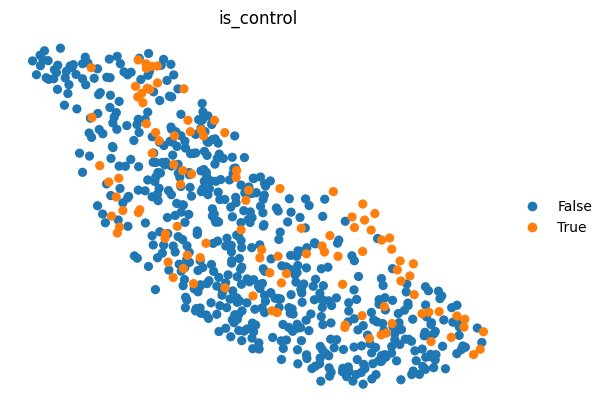

Processing dataset: xaira_HEK293T


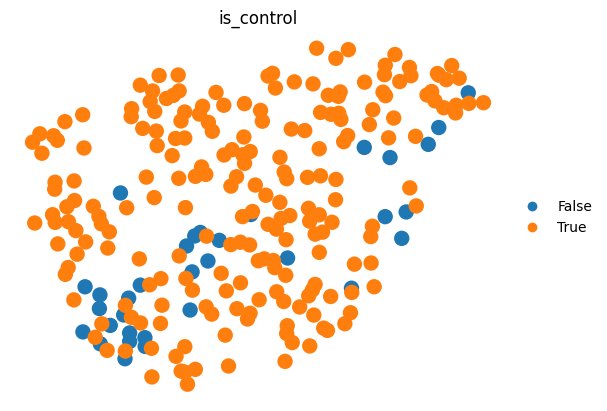

Processing dataset: replogle


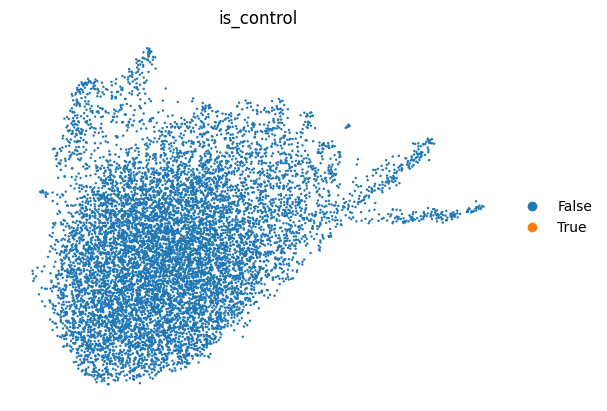

In [ ]:
for dataset in ['xaira_HCT116', 'xaira_HEK293T', 'replogle']:
    print(f'Processing dataset: {dataset}')
    adata = ad.read_h5ad(f'resources/extended_data/{dataset}_bulk.h5ad')

    adata.X = adata.layers['lognorm']
    sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=True)
    sc.pp.pca(adata)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)

    sc.pl.umap(adata,
        color=['is_control'],
        frameon=False,
        wspace=0.5)

# Assemble the results from differnet runs

In [ ]:
!rm -r resources/results/all_main/

In [ ]:
import os
import shutil
import yaml
from pathlib import Path
from collections import OrderedDict

base_dir = 'resources/results/'
save_dir = 'resources/results/all_main/'
runs = ['op', 'nakatake', 'norman', 'replogle', 'adamson']

os.makedirs(save_dir, exist_ok=True)

# 1. Copy one version of the identical files
identical_files = ['method_configs.yaml', 'metric_configs.yaml']
for fname in identical_files:
    src = os.path.join(base_dir, f'{runs[0]}_run', fname)
    dst = os.path.join(save_dir, fname)
    shutil.copyfile(src, dst)
    print(f"Copied identical file: {fname}")

# 2. Merge dataset_uns.yaml by appending all contents
merged_uns = []
for run in runs:
    path = os.path.join(base_dir, f'{run}_run', 'dataset_uns.yaml')

    with open(path, 'r') as f:
        data = yaml.safe_load(f)
        merged_uns.extend(data)
        
with open(os.path.join(save_dir, 'dataset_uns.yaml'), 'w') as f:
    yaml.dump(merged_uns, f)
print("Merged: dataset_uns.yaml")

# 3. Merge score_uns.yaml similarly
merged_scores = []
for run in runs:
    path = os.path.join(base_dir, f'{run}_run', 'score_uns.yaml')

    with open(path, 'r') as f:
        data = yaml.safe_load(f)
        # - remove those with missing (because of the metric)
        data = [d for d in data if d is not None and 'missing' not in str(d)]
        
        # print(str(data[0]))
        # aa
        # missing
        if data:
            if isinstance(data, dict):
                merged_scores.append(data)
            elif isinstance(data, list):
                merged_scores.extend(data)
            else:
                print(f"Unexpected format in {path}: {type(data)}")

with open(os.path.join(save_dir, 'score_uns.yaml'), 'w') as f:
    yaml.dump(merged_scores, f)
print("Merged: score_uns.yaml")

# 4. Merge trace.txt with deduplication
seen_lines = OrderedDict()
for run in runs:
    path = os.path.join(base_dir, f'{run}_run', 'trace.txt')
    
    with open(path, 'r') as f:
        for line in f:
            seen_lines[line] = None

with open(os.path.join(save_dir, 'trace.txt'), 'w') as f:
    for line in seen_lines.keys():
        f.write(line)
df = pd.read_csv(os.path.join(save_dir, 'trace.txt'), sep='\t')
df = df.drop_duplicates(subset=['name'])
df.to_csv(os.path.join(save_dir, 'trace.txt'), sep='\t')
print("Merged: trace.txt (duplicates removed)")

# 5. Copy other unknown files/directories
all_known = set(identical_files + ['dataset_uns.yaml', 'score_uns.yaml', 'trace.txt'])

for run in runs:
    run_dir = Path(base_dir) / f'{run}_run'
    for file_path in run_dir.iterdir():
        if file_path.name in all_known:
            continue

        dest_path = Path(save_dir) / file_path.name

        if dest_path.exists():
            dest_path = Path(save_dir) / f"{file_path.stem}_{run}{file_path.suffix}"

        if file_path.is_file():
            shutil.copyfile(file_path, dest_path)
            print(f"Copied unique file: {file_path.name} → {dest_path.name}")
        elif file_path.is_dir():
            shutil.copytree(file_path, dest_path)
            print(f"Copied unique directory: {file_path.name} → {dest_path.name}")

Copied identical file: method_configs.yaml
Copied identical file: metric_configs.yaml
Merged: dataset_uns.yaml
Merged: score_uns.yaml
Merged: trace.txt (duplicates removed)
Copied unique file: state.yaml → state.yaml
Copied unique file: op_.celloracle.celloracle.prediction.h5ad → op_.celloracle.celloracle.prediction.h5ad
Copied unique file: scplus_mdata.h5mu.2DAaAA8E → scplus_mdata.h5mu.2DAaAA8E
Copied unique file: op_.negative_control.negative_control.prediction.h5ad → op_.negative_control.negative_control.prediction.h5ad
Copied unique file: op_.scenicplus.scenicplus.prediction.h5ad → op_.scenicplus.scenicplus.prediction.h5ad
Copied unique file: op_.portia.portia.prediction.h5ad → op_.portia.portia.prediction.h5ad
Copied unique file: op_.granie.granie.prediction.h5ad → op_.granie.granie.prediction.h5ad
Copied unique file: op_.scprint.scprint.prediction.h5ad → op_.scprint.scprint.prediction.h5ad
Copied unique file: op_.pearson_corr.pearson_corr.prediction.h5ad → op_.pearson_corr.pearso

# Rename grnboost2 to grnboost

In [ ]:
import os

target_dir = 'resources/results/all_main'

for root, _, files in os.walk(target_dir):
    for fname in files:
        fpath = os.path.join(root, fname)

        # Skip binary files (optional safety)
        try:
            with open(fpath, 'r', encoding='utf-8') as f:
                content = f.read()
        except UnicodeDecodeError:
            continue  # likely a binary file, skip it

        if 'grnboost2' in content:
            content = content.replace('grnboost2', 'grnboost')
            with open(fpath, 'w', encoding='utf-8') as f:
                f.write(content)
            print(f"Updated: {fpath}")

Updated: resources/results/all_main/trace.txt
Updated: resources/results/all_main/method_configs.yaml
Updated: resources/results/all_main/score_uns.yaml


## Create Nakatake test

In [ ]:
adata = ad.read_h5ad('resources/grn_benchmark/inference_data/nakatake_rna.h5ad')
# Sample 100 cells
sampled_cells = adata.obs.sample(n=100, random_state=0).index

# Sample 2000 genes
sampled_genes = adata.var.sample(n=2000, random_state=0).index

# Subset the AnnData object
adata_subset = adata[sampled_cells, sampled_genes].copy()
adata_subset.write('resources_test/grn_benchmark/inference_data/nakatake_rna.h5ad')

In [ ]:
adata = ad.read_h5ad('resources/grn_benchmark/evaluation_data/nakatake_bulk.h5ad')
# Sample 100 cells
sampled_cells = adata.obs.sample(n=100, random_state=0).index

# Sample 2000 genes
sampled_genes = adata.var.sample(n=2000, random_state=0).index

# Subset the AnnData object
adata_subset = adata[sampled_cells, sampled_genes].copy()
adata_subset.write('resources_test/grn_benchmark/evaluation_data/nakatake_bulk.h5ad')